In [1]:
#!/usr/bin/env python
"""
Definition of test problems
--------------------------------------------------------------------------
Created December 10, 2022 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha, Silvia Gazzola, Connor Sanderford, and Ugochukwu Obinna"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and csanderf@asu.edu; connorsanderford@gmail.com"
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
import trips.phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
from trips.testProblems import *
from trips.operators import *
from trips.helpers import *
from trips.solvers.gks_all import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Hybrid_LSQR import *
from scipy.linalg import qr

#### In this notebook we illustrate how to use the Deblurring class. The main features are:
1. Define a Deblurring problem where the forward operator can be formed explicitly as a matrix
 - 1.1 We show how to use SVD, compute the singular values of the operator, and illustrate the truncated SVD solution
 - 1.2 We use regularization methods for computing an approximate solution
2. Define a Deblurring problem where the forward operator is defined as a function and test solving the problem


#### 1. Define e tomography problem where the forward operator can be formed explicitly as a matrix

###### We define an operator, choose an image of any given size and plot the true phantom and the sinograpm as follows:

In [ ]:
# Deblurring example test problem
Deblur = Deblurring()
# In the class Deblurring we have can define the type of problem to be used.
generate_matrix = True #Defines a blurring operator where the forward operator matrix is formed explicitly
nx = 64 # Define the first dimension of the image
ny = 64 # Define the second dimension of the image
spread = 1 # The PSF parameter
choose_image = 'satellite' #The choice of the image:
# Options for the choice of the image are Himage, satellite64, satellite128, edges
if generate_matrix == True:
        shape = (nx, ny)
        spreadnew = (spread, spread)
        A = Deblur.forward_Op_matrix(spreadnew, nx, ny)
x_true = Deblur.gen_true(choose_image)
b_true = Deblur.gen_data(x_true, generate_matrix)
(b, delta) = Deblur.add_noise(b_true, opt = 'Gaussian', noise_level = 0.01)

In [ ]:
# Compute a solution Golub-Kahan
projection_dim = 10
b_vec = b.reshape((-1,1))
(U, B, V) = golub_kahan(A, b_vec, projection_dim)
VV = V
UU = U[:, 0:-1]
HH = B[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_GKahan = VV.dot(y_tikh)
plt.imshow(x_GKahan.reshape((nx,ny)))

###### Display the true image, the blurred image, and the blurred and noisy image

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((nx, ny)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx, ny)))

In [ ]:
# Deblurring class has a method plot_rec that plots the reconstructions. 
# We can choose to save the images or not through save_imgs = True or False
Deblur.plot_rec(x_true.reshape((shape)), save_imgs = True, save_path='./saveImagesDeblurring'+'rec'+choose_image)

##### 1.1. Compute the SVD of the operartor $A$ and plot the singlar values and the singular vectors
###### If the parameter is 'A' then we give the full operator to the function plot_singular_values_svd. The SVD is then computed and the singlar values are plotted. If the parameter is 'S' then we have precomputed the SVD from which we have S and the function plot_singular_values_svd will only plot the singular values. The same applies for plotting the singular vectors. If the operaror is not given, we give the matrix V.

In [ ]:
# If the operator is sparse, we convert it to dense A.todense()
plot_singular_values_svd(Operator = A , parameter = 'A')
# If the operator is in the matrix form, but very large and sparse, the following commands can be used to compute the SVD
# import scipy
# [U, S, V] = scipy.sparse.linalg.svds(A, 100)
# 100 defines the number of singular values to be computed

In [ ]:
plot_singular_vectors_svd(Operator = A, size = nx, parameter = 'A')

##### 1.1. Compute the truncated SVD solution of a problem by specifying how many singular values you want to keep after truncation

In [ ]:
truncated_value = 40
b_vec = b.reshape((-1,1))
x_tsvd = TruncatedSVD_sol(A, truncated_value, b_vec)
plt.imshow(x_tsvd.reshape((nx, ny)))
plt.axis('off')

#### 1.2 Compute an approximate solution by using Generalized Krylov Subspace method (GKS)

In [ ]:
# First we compute a naive solution
x_naive = A.T@b.reshape((-1,1))

In [4]:
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter = 3, regparam = 'dp', x_true = x_true.reshape(-1,1), delta = delta)

running GKS...: 100%|██████████| 3/3 [00:20<00:00,  6.91s/it]


In [ ]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(15,4))
plt.subplot(1,4,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,4,2), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx,ny)))
plt.subplot(1,4,3), plt.title('x_naive'), plt.axis('off'), plt.imshow(x_naive.reshape((nx,ny)))
plt.subplot(1,4,4), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx, ny)))

2. Define a deblurring problem where the forward operator is defined as a function and test solving the problem

In [ ]:
#%reset

In [28]:
A.shape

(262144, 262144)

In [3]:
# To run the following, run the cell at the beginning of the notebook to import 
Deblur2 = Deblurring()
nx = 512
ny = 512
A = Deblur2.forward_Op([11,11], 1.5, nx, ny)
choose_image = 'hubble'
generate_matrix = False
x_true = Deblur2.gen_true(choose_image)
b_true = Deblur2.gen_data(x_true, generate_matrix)
(b, delta) = Deblur2.add_noise(b_true, opt= 'Gaussian', noise_level = 0.01)
b_vec = b.reshape((-1,1))

data already in the path.


In [ ]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((nx,ny)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx,ny)))

In [7]:
from trips.decompositions import *
from scipy.optimize import fminbound

In [5]:
def gcvd(A,L,b):
    U, _, _, S, La = gsvd(A,L)
    # print(b.shape)
    # print(U.shape)
    bhat = U.T @ b
    l = np.diag(La)
    s = np.diag(S)
    #mu = fminbound(gcv_funct, 0, 100, args=(s, l, bhat))
    # mu = op.fminbound(func = gcv_funct, x1 = 1e-09, x2 = 1e2, args=(s,l,bhat),
    #                    xtol=1e-12, maxfun=1000, full_output=0, disp=0)
    mu = bisection(gcv_funct,s,l,bhat,0,100)
    return mu
def gcv_funct(mu, s, l, bhat):
    num = (l**2 * bhat / (s**2 + mu * l**2))**2
    num = np.sum(num)
    den = (l**2 / (s**2 + mu * l**2))**2
    den = np.sum(den)
    #den = bhat.size - np.trace(np.diag(s) @ np.diag(den))
    G = num / den
    return G

def bisection(f,s,l,bhat, a, b):
    k = 2
    eps = 1e-15
    while abs(b - a) > abs(b) * eps:
        x = (a + b) / 2
        if f(x,s,l,bhat) * f(b,s,l,bhat) > 0:
            b = x
        else:
            a = x
        k += 1
    return b




In [6]:
def l2lq_mp(A, b, L, q, epsilon, iter, delta, nx, nt, x_true):
    Rerr = []
    ml, nl = L.shape
    tol = 0.001
    b = b.reshape(-1,1)
    x = A.T @ b
    v = A.T @ b
    V = v / np.linalg.norm(v)
    AV = A @ V
    # Rerr = np.zeros(iter + 1)
    LV = L @ V
    v = A @ x
    u = L @ x
    storemu = []
    saveX = []
    storegrad = []
    storerel_err = []
    for k in range(0, iter):
        x_old = x
        u = L @ x
        #print('x',x.shape)
        wr = (u**2 + epsilon**2)**(q/2 - 1)
        #=====================================
        AA = AV
        LL = LV * wr
        QA, RA = qr(AA, mode='economic')
        _, RL = qr(LL, mode='economic')
        #print(QA.shape,RA.shape,RL.shape)
        # mu = gcvd(RA,RL,QA.T @ b) # use gsvd based gcv
        mu = generalized_crossvalidation(QA, RA, RL, b)#['x'].item() # find ideal lambda by crossvalidation
        storemu.append(mu)
        y,_,_,_ = np.linalg.lstsq(np.concatenate((RA, np.sqrt(mu) * RL)), np.concatenate((QA.T@ b, np.zeros((RL.shape[0],1)))),rcond=None)
        x = V@y
        saveX.append(x)
        if k >= RL.shape[0]:
            break
        v = AV@y
        v = v - b
        u = LV @ y
        ra = AV @ y - b
        ra = A.T @ ra
        rb = wr * (LV @ y)
        rb = L.T @ rb
        r = ra + mu * rb
        r = r - V @ (V.T @ r)
        r = r - V @ (V.T @ r)
        storegrad.append(np.linalg.norm(r))
        storerel_err.append(np.linalg.norm(x_old - x) / np.linalg.norm(x_old))
        rel_err = np.linalg.norm(x_true.reshape((-1,1))-x.reshape((-1,1)))/np.linalg.norm(x_true.reshape((-1,1)))
        Rerr.append(rel_err)
        vn = r / np.linalg.norm(r)
        V = np.column_stack((V, vn))
        Avn = A @ vn
        AV = np.column_stack((AV, Avn))
        Lvn = vn
        Lvn = L*vn
        LV = np.column_stack((LV, Lvn))
    return x, np.array(storerel_err),np.array(storemu), Rerr

In [7]:
x_l2lq_mp, err_l2lq, mu_l2lq, rel_err_mp = l2lq_mp(A, b, L, q = 1, epsilon = 0.1, iter = 20, delta = 0, nx = 128, nt = 33, x_true = x_true)

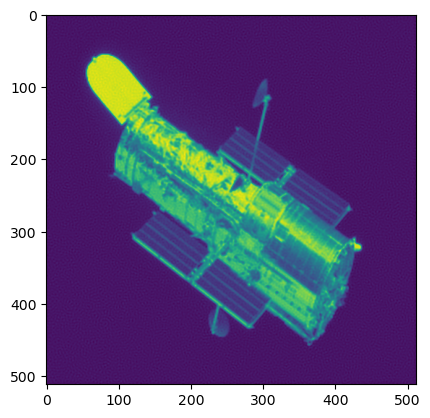

In [8]:
plt.imshow(x_l2lq_mp.reshape((nx,ny)))

In [9]:
rel_err_mp

[0.10161617092347436,
 0.06544719470780148,
 0.052691349552267217,
 0.04558507563603615,
 0.04125762589912708,
 0.038377924141666755,
 0.036460914274638705,
 0.03514787144262486,
 0.034327431127419164,
 0.0338739322293947,
 0.03376910527737858,
 0.033961919004125755,
 0.03439880577925088,
 0.035084490115301514,
 0.03602955021761765,
 0.03718602537486665,
 0.03854070064146754,
 0.040072543057696364,
 0.04176812837862256,
 0.0435983860218186]

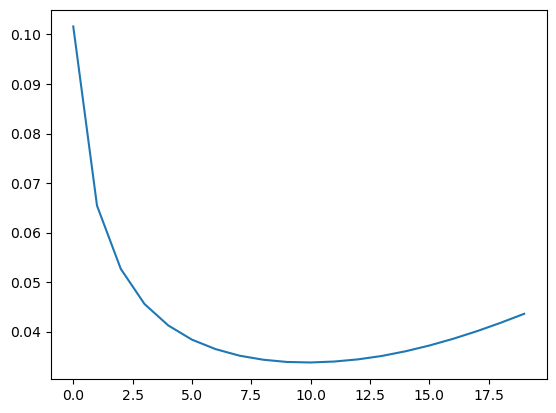

In [10]:
plt.plot(rel_err_mp)

In [11]:
from trips.decompositions import gsvd
def l2lq_uu(A, b, L, q, epsilon, iter, delta, nx, nt, x_true):
    Rerr = []
    ml, nl = L.shape
    tol = 0.001
    b = b.reshape(-1,1)
    x = A.T @ b
    v = A.T @ b
    V = v / np.linalg.norm(v)
    AV = A @ V
    # Rerr = np.zeros(iter + 1)
    LV = L @ V
    v = A @ x
    u = L @ x
    storemu = []
    saveX = []
    storegrad = []
    storerel_err = []
    for k in range(0, iter):
        x_old = x
        u = L @ x
        wr = (u**2 + epsilon**2)**(q/2 - 1)
        #=====================================
        AA = AV
        LL = LV * wr
        QA, RA = qr(AA, mode='economic')
        _, RL = qr(LL, mode='economic')
        #U, _, Z, C, S = gsvd(RA,RL)
        mu = gcvd(RA,RL,QA.T @ b) # use gsvd based gcv
        #mu = generalized_crossvalidation(QA@U, C, S, b)
        storemu.append(mu)
        # y,_,_,_ = np.linalg.lstsq(np.concatenate((C, np.sqrt(mu) * S)), np.concatenate(((QA@U).T@ b, np.zeros((S.shape[0],1)))),rcond=None)
        # x = V@np.linalg.inv(Z.T)@y
        y,_,_,_ = np.linalg.lstsq(np.concatenate((RA, np.sqrt(mu) * RL)), np.concatenate((QA.T@ b, np.zeros((RL.shape[0],1)))),rcond=None)
        x = V@y
        saveX.append(x)
        if k >= RL.shape[0]:
            break
        v = AV@y
        v = v - b
        u = LV @ y
        ra = AV @ y - b
        ra = A.T @ ra
        rb = wr * (LV @ y)
        rb = L.T @ rb
        r = ra + mu * rb
        r = r - V @ (V.T @ r)
        r = r - V @ (V.T @ r)
        storegrad.append(np.linalg.norm(r))
        storerel_err.append(np.linalg.norm(x_old - x) / np.linalg.norm(x_old))
        rel_err = np.linalg.norm(x_true.reshape((-1,1))-x.reshape((-1,1)))/np.linalg.norm(x_true.reshape((-1,1)))
        Rerr.append(rel_err)
        vn = r / np.linalg.norm(r)
        V = np.column_stack((V, vn))
        Avn = A @ vn
        AV = np.column_stack((AV, Avn))
        Lvn = vn
        Lvn = L*vn
        LV = np.column_stack((LV, Lvn))
    return x, np.array(storerel_err),np.array(storemu), Rerr

In [12]:
#L = sparse.identity(nx**2)

x_l2lq_uu, err_l2lq, mu_l2lq, rel_err_uu = l2lq_uu(A, b, L, q = 1, epsilon = 0.1, iter = 20, delta = 0, nx = 128, nt = 33, x_true = x_true)

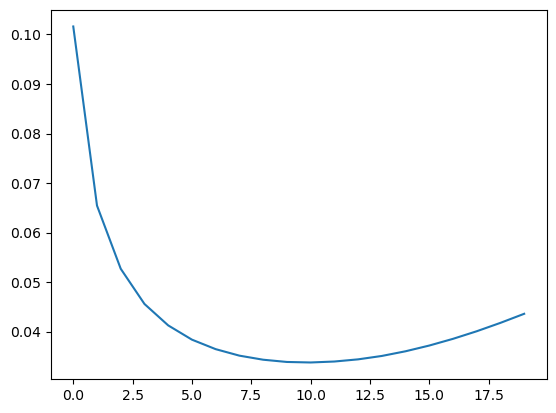

In [13]:
plt.plot(rel_err_uu)

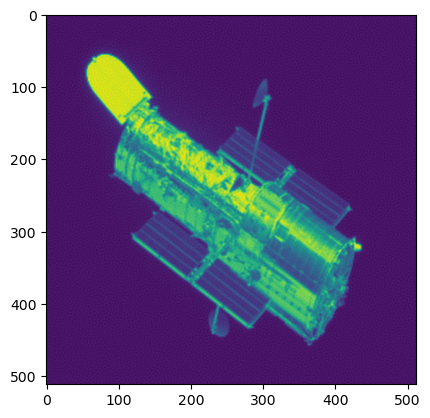

In [14]:
plt.imshow(x_l2lq_uu.reshape((nx,ny)))

In [15]:
rel_err_uu

[0.10161617008420522,
 0.06544718387011213,
 0.05269133616171742,
 0.045585058300651383,
 0.041257604206930906,
 0.038377898392060704,
 0.03646088742331229,
 0.03514784906810102,
 0.03432742252083769,
 0.03387395468229557,
 0.033769181504227204,
 0.03396207423039478,
 0.0343990672338786,
 0.03508489132296933,
 0.03603012706393261,
 0.0371868032828536,
 0.038541700485662106,
 0.040073780905212346,
 0.04176961641160362,
 0.0436001302600195]

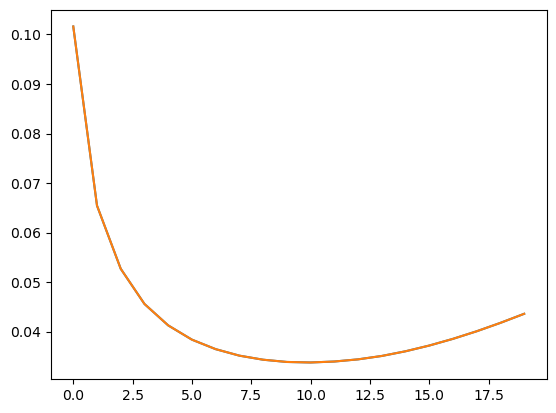

In [16]:
plt.plot(rel_err_uu)
plt.plot(rel_err_mp)

In [17]:
np.array(rel_err_uu)-np.array(rel_err_mp)

array([-8.39269140e-10, -1.08376894e-08, -1.33905498e-08, -1.73353848e-08,
       -2.16921962e-08, -2.57496061e-08, -2.68513264e-08, -2.23745238e-08,
       -8.60658148e-09,  2.24529009e-08,  7.62268486e-08,  1.55226269e-07,
        2.61454628e-07,  4.01207668e-07,  5.76846315e-07,  7.77907987e-07,
        9.99844195e-07,  1.23784752e-06,  1.48803298e-06,  1.74423820e-06])

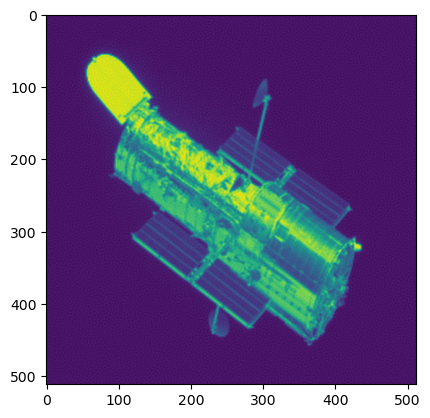

In [18]:
plt.imshow(x_l2lq_uu.reshape((nx, ny)))

##### Illustrate the ill-posedness of some inverse problem examples and show the need for regularization
<p>In this example we illustrate the following:

Step 3: Solve the regularized problem with GKS and Hybrid_lsqr that solves

$\|\mathbf A{\mathbf x} - {\mathbf b}\|^2_2 + \lambda \|\mathbf L\mathbf x\|_2^2$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator for GKS and $L = I$ for Hybrid_lsqr, for an computed value of the regularization parameter $\lambda$. 


In [ ]:
b_vec = b.reshape((-1,1))
(x_hybrid_gmres, info_hybrid_gmres) = hybrid_gmres(A, b_vec, n_iter = 30, regparam = 'dp', x_true = x_true, delta = delta)

In [ ]:
info_hybrid_gmres['relError']

In [ ]:
b_vec = b.reshape((-1,1))
(x_hybrid_lsqr, info_hybrid_lsqr) = hybrid_lsqr(A, b_vec, n_iter = 100, regparam = 'dp', x_true = x_true, delta = delta)

In [ ]:
info_hybrid_lsqr['relError']

In [ ]:
plt.imshow(x_hybrid_lsqr.reshape((nx, ny)))
cmap="inferno"

In [ ]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info_gks) = GKS(A, data_vec, L, projection_dim=2, n_iter = 10, regparam = 'dp', x_true = x_true.reshape(-1,1), delta = delta)

In [ ]:
info_gks['relError']

Solve the regularized problem

$\|\mathbf A{\mathbf x} - {\mathbf b}\|_2 + \lambda \|\mathbf L\mathbf x\|_q$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. The value of $q$ can be choosen from (0, 2].

In [ ]:
# Compute a solution by GKS
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_mmgks, info_mmgks) = MMGKS(A, data_vec, L, pnorm=2, qnorm=1, projection_dim=1, n_iter = 20, regparam = 'gcv', x_true = x_true.reshape(-1,1), delta = delta)

In [ ]:
rre = info_mmgks['relError']

In [ ]:
rre

In [ ]:
plt.plot(rre)

In [ ]:
plt.imshow(x_mmgks.reshape((nx, ny)))

In [ ]:
plt.plot(info_mmgks['relError'])
plt.plot(info_gks['relError'])
plt.plot(info_hybrid_lsqr['relError'])
plt.plot(info_hybrid_gmres['relError'])

In [ ]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(15,4))
plt.subplot(1,5,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,5,2), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((nx,ny)))
plt.subplot(1,5,3), plt.title('x_hybrid_gmres'), plt.axis('off'), plt.imshow(x_hybrid_gmres.reshape((nx,ny)))
plt.subplot(1,5,4), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx,ny)))
plt.subplot(1,5,5), plt.title('x_mmgks'), plt.axis('off'), plt.imshow(x_mmgks.reshape((nx,ny)))